# TP1 Simulación

## Ejercicio 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
from statistics import mean, variance

def own_rand():
    own_rand.x_n = (own_rand.x_n * 1013904223 + 1664525) % (2 ** 32)
    return own_rand.x_n
own_rand.x_n = (97811 + 97811 + 97811)/3


In [2]:
result_1a = [own_rand() for i in range(6)]
result_1a

[192755738.0,
 1392371104.0,
 4161305600.0,
 1626565120.0,
 2483796992.0,
 3689425408.0]

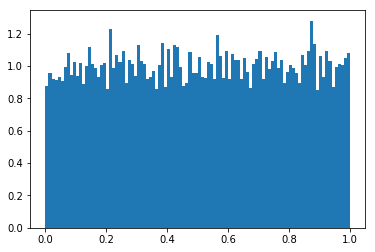

In [3]:
def own_rand_u():
    return float(own_rand())/(2**32)

def rand_u_vector(n):
    return [own_rand_u() for i in range(n)]
result_1b = rand_u_vector(10**5)
plt.hist(result_1b, bins=100, density=True)
plt.show()

## Ejercicio 2

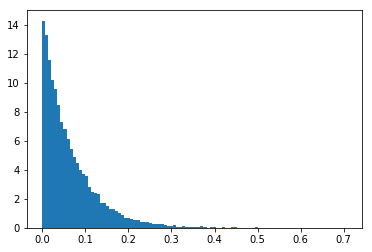

In [4]:
def make_exponential_dist_inverse(lamda):
    def inverse_dist(u):
        return -math.log(u)/lamda
    return inverse_dist

inverse_dist = make_exponential_dist_inverse(15)
inverse_dist = np.vectorize(inverse_dist)

exponential_sample = inverse_dist(rand_u_vector(10**5))

bins_values, bins_edges, _ = plt.hist(exponential_sample,bins=100, density=True)
bins_exp = zip(bins_values, bins_edges[:-1])
plt.show()

In [5]:
mean_exp = mean(exponential_sample)
mode_exp = max(bins_exp, key=(lambda x: x[0]))[1] # Use the first argument as the key to be maxed but return the left edge of the bin which it belongs to
variance_exp = variance(exponential_sample, mean_exp)
mean_exp, mode_exp, variance_exp

(0.065389573267964449, 2.7975033558250362e-06, 0.0042533181997071864)

## Ejercicio 3

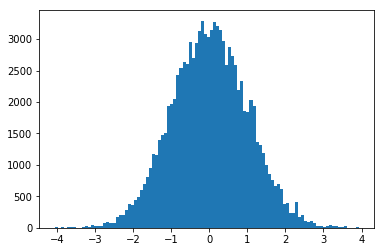

In [6]:
def make_normal_dist_inverse(mu, sigma):
    def inverse_dist(u):
        return norm.ppf(u) * sigma + mu
    return inverse_dist

normal_inverse_dist = make_normal_dist_inverse(0, 1)
normal_inverse_dist = np.vectorize(normal_inverse_dist)
normal_sample = normal_inverse_dist(rand_u_vector(10**5))
bins_values, bins_edges, _ = plt.hist(normal_sample, bins=100)
bins_normal = zip(bins_values, bins_edges[:-1])
plt.show()

***Note: Compared with the expected value(0,0,1), the ones generated are pretty close***

## Ejercicio 4

In [7]:
# def norm_pdf(x, loc, scale):
#    return norm.pdf(x, loc=loc, scale=scale)

#def make_norm_acc_rej(loc=0, scale=1):
#    def norm_acc_rej():
#        start = True
#        while start or y > norm_pdf(x, loc, scale):
#            start = False
#            x = (own_rand() - 0.5) * scale + loc
#            y = own_rand() * norm_pdf(loc, loc, scale)
#        return y
#   return norm_acc_rej

# def norm_acc_rej_vector(qty, loc=0, scale=1):
#     own_acc_rej = make_norm_acc_rej(loc, scale)
#     return [own_acc_rej() for i in range(qty)]

# normal_sample2 = norm_acc_rej_vector(10, 35, 5)

# bins_values, bins_edges, _ = plt.hist(normal_sample2, bins=100, color='#ff000055', density=True)
# bins_normal = zip(bins_values, bins_edges[:-1])

# normal_control_group = [np.random.rand() for i in range(10**5)]
# plt.hist(normal_sample2, bins=100, color='#00ff0055', density=True)
                                    
# plt.show()


# Ejercicio 5



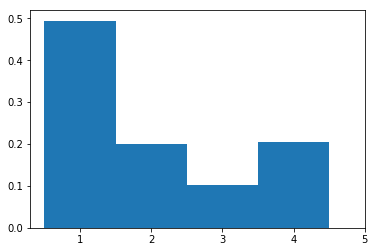

In [8]:
def empiric_inv_distribution(u):
    if u <= 0.5:
        return 1
    elif u <= 0.7:
        return 2
    elif u <= 0.8:
        return 3
    else:
        return 4
    
def gen_empiric():
    return empiric_inv_distribution(own_rand_u())

empiric_sample = [gen_empiric() for i in range(10**5)]


bins_empiric = np.arange(0.5, 5.5, 1)

plt.hist(empiric_sample, bins=bins_empiric, density=True)
plt.xticks(np.arange(1,6,1))
plt.show()

## Ejercicio 6


- Cada lanzamiento de la moneda se puede modelar con una variable aleatoria de distribución Bernoulli. 
- El experimento de lanzar una moneda se puede modelar como una variable aleatoria de distribución Geometrica.


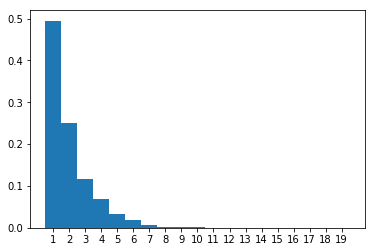

In [9]:
def bernoulli_random():
    return 1 if own_rand_u() < 0.5 else 0

def geometric_random():
    qty = 1
    while bernoulli_random() != 1:
        qty += 1
    return qty

geometric_sample = [geometric_random() for i in range(10**5)]

bins_geometric = np.arange(0.5, 20, 1)

plt.hist(geometric_sample, bins=bins_geometric, density=True)
plt.xticks(np.arange(1,20,1))
plt.show()

## Ejercio 7

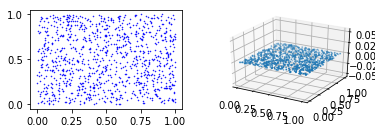

In [10]:
from mpl_toolkits.mplot3d import Axes3D
uniform_random_sample = rand_u_vector(10**3)
uniform_random_sample_x = uniform_random_sample[:-2]
uniform_random_sample_y = uniform_random_sample[1:-1]
uniform_random_sample_z = uniform_random_sample[2:]



plt.subplot(221)
plt.plot(uniform_random_sample_x, uniform_random_sample_y, 'bo', markersize=0.5)

plt.subplot(222, projection='3d')
plt.scatter(uniform_random_sample_x, uniform_random_sample_y, uniform_random_sample_z)
plt.show()

In [11]:
uniform_random_sample_z

[0.2148517370223999,
 0.4862842559814453,
 0.7183879613876343,
 0.8036708831787109,
 0.35742223262786865,
 0.05587196350097656,
 0.741329550743103,
 0.1335124969482422,
 0.4794849157333374,
 0.9272174835205078,
 0.18126332759857178,
 0.32761192321777344,
 0.45603978633880615,
 0.22532081604003906,
 0.9131892919540405,
 0.5109691619873047,
 0.1620868444442749,
 0.07518196105957031,
 0.8121074438095093,
 0.8085842132568359,
 0.47262609004974365,
 0.6018009185791016,
 0.753017783164978,
 0.3454570770263672,
 0.2626575231552124,
 0.9301776885986328,
 0.6109203100204468,
 0.24658775329589844,
 0.40718114376068115,
 0.18531227111816406,
 0.2608150243759155,
 0.6369762420654297,
 0.7811969518661499,
 0.4922046661376953,
 0.5777019262313843,
 0.6416225433349609,
 0.25970494747161865,
 0.9758548736572266,
 0.436581015586853,
 0.3855266571044922,
 0.7177051305770874,
 0.7612628936767578,
 0.7124522924423218,
 0.9936885833740234,
 0.030197501182556152,
 0.9734287299215794,
 0.0574033260345459,
 0

## Ejercicio 8

In [53]:
from collections import Counter

def geometric_prob(q, n):
    return math.pow(q, n-1) * (1-q)

def t(significance):
    n = 1
    acum = 0
    while acum < (1 - significance):
        acum += geometric_prob(0.5, n)
        n += 1
    return n

def d_func(geometric_sample):
    N = Counter(geometric_sample)
    npi = {n : len(geometric_sample) * geometric_prob(0.5, n) for n in N.keys()}
    result = 0
    for i in N.keys():
        result += math.pow(N[i] - npi[i], 2) / npi[i]
    return result

if d_func(geometric_sample) < t(0.01):
    print('Los datos responden a una distribucion geometrica')
else:
    print('Los datos no responden a una distribucion geometrica')

Los datos no responden a una distribucion geometrica
